The dataset comes from [this website](https://www.cityscapes-dataset.com/dataset-overview/) and you can download it at [this direct link](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+8+-+Participez+%C3%A0+la+conception+d'une+voiture+autonome/P8_Cityscapes_gtFine_trainvaltest.zip).

A faire :
- [x] Comprendre pourquoi les métriques sont aussi basses. Cherche de nouvelles métrique. Enregistrer l'entrainement avec loss, accuracy, etc.
    Les métriques ont l'air bonnes, je les ai refaites via une autre méthode et elles sont similaires.
- [ ] Essayer de décrire plus ce que ces métriques représentent
- [ ] Essayer de trouver d'autres métriques
- [ ] Essayer d'hériter des classes de Keras pour faire un générator qui sera passé dans train de keras segmentation (en premier, rechercher les paramètres de keras_segmentation.train)

Ressources :
1. Un guide classique sur la segmentation image avec exactement ce dataset [ici](https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html)
2. A entrainé Unet sur le dataset [ici](https://github.com/srihari-humbarwadi/cityscapes-segmentation-with-Unet)
3. Kaggle d'entrainement de PSPNet sur le dataset [ici](https://www.kaggle.com/code/santhalnr/cityscapes-image-segmentation-pspnet/notebook)
4. La doc de python [ici](https://docs.python.org/3/index.html)
   

# Gathering the data

## Downloading

In [1]:
import zipfile
import urllib

from url import file1_url, file2_url

# Will try to download the files

# Dataset archive whith labels
file_path = 'P8_Cityscapes_gtFine_trainvaltest.zip'
# Dataset archive with images
file_path_2 = 'P8_Cityscapes_leftImg8bit_trainvaltest.zip'

# Check if file exists
if not os.path.isfile(file_path):
    print(f'{file_path} archive does not exist. Downloading from internet...')
    urllib.request.urlretrieve(file1_url, file_path)
    print('Download complete.')

# Check if file exists
if not os.path.isfile(file_path_2):
    print(f'{file_path_2} archive does not exist. Downloading from internet...')
    urllib.request.urlretrieve(file2_url, file_path_2)
    print('Download complete.')


## Extraction

In [2]:
# Create another directory and extract the file in it
path_to_extract = f'dataset/'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(path_to_extract)

# Create another directory and extract the file in it
with zipfile.ZipFile(file_path_2, 'r') as zip_ref:
    zip_ref.extractall(path_to_extract)

# Sorting images and preprocessing

We know that we need to sort images into folder for training, testing and validation.

## Sorting images into folders

# DECONNE GRAVE

In [58]:
import shutil
import os
import random
from tqdm.autonotebook import tqdm
import numpy as np
from labels import *
import cv2
import matplotlib.pyplot as plt

training_folder = r"dataset\leftImg8bit\train"

# List of all subfolders
subfolders = os.listdir(training_folder)

# List of all images paths in the subfolders
images = []
for subfolder in subfolders:
    for image in os.listdir(os.path.join(training_folder, subfolder)):
        images.append(os.path.join(training_folder, subfolder, image))


# Same for labelling
labelling_folder = r"dataset\gtFine\train"

# List of all subfolders
subfolders = os.listdir(labelling_folder)

# List of all images paths in the subfolders
labels_images = []
for subfolder in subfolders:
    for image in os.listdir(os.path.join(labelling_folder, subfolder)):
        if image.endswith('labelIds.png'):
            labels_images.append(os.path.join(labelling_folder, subfolder, image))

tuple_images_labels = list(zip(images, labels_images))


# Same for validation
validation_folder = r"dataset\leftImg8bit\val"

# List of all subfolders
subfolders = os.listdir(validation_folder)

# List of all images paths in the subfolders
val_images = []
for subfolder in subfolders:
    for image in os.listdir(os.path.join(validation_folder, subfolder)):
        val_images.append(os.path.join(validation_folder, subfolder, image))


# Same for labelling
validation_labelling_folder = r"dataset\gtFine\val"

# List of all subfolders
subfolders = os.listdir(validation_labelling_folder)

# List of all images paths in the subfolders
val_labels_images = []
for subfolder in subfolders:
    for image in os.listdir(os.path.join(validation_labelling_folder, subfolder)):
        if image.endswith('labelIds.png'):
            val_labels_images.append(os.path.join(validation_labelling_folder, subfolder, image))

tuple_val_images_labels = list(zip(val_images, val_labels_images))

In [59]:
# Creating folder training_data
training_data_folder = r"processed_data\training_data"
if os.path.exists(training_data_folder):
    shutil.rmtree(training_data_folder)
os.makedirs(training_data_folder)

# Creating training_labels folder
training_labels_folder = r"processed_data\training_labels"
if os.path.exists(training_labels_folder):
    shutil.rmtree(training_labels_folder)
os.makedirs(training_labels_folder)

for image, label in random.choices(tuple_images_labels, k=1000):
    # get image name
    image_name = os.path.basename(image)[:-16] + '.png'
    # Copy image to training_data folder and rename it
    shutil.copy(image, os.path.join(training_data_folder, image_name))
    # Copy label to training_labels folder
    shutil.copy(label, os.path.join(training_labels_folder, image_name))




# Creating validation_data folder
validation_data_folder = r"processed_data\validation_data"
if not os.path.exists(validation_data_folder):
    os.makedirs(validation_data_folder)

# Creating validation_labels folder
validation_labels_folder = r"processed_data\validation_labels"
if not os.path.exists(validation_labels_folder):
    os.makedirs(validation_labels_folder)

for image, label in random.choices(tuple_val_images_labels, k=10):
    # get image name
    image_name = os.path.basename(image)[:-16] + '.png'
    # Copy image to validation_data_folder folder and rename it
    shutil.copy(image, os.path.join(validation_data_folder, image_name))
    # Copy label to validation_labels_folder folder
    shutil.copy(label, os.path.join(validation_labels_folder, image_name))

# Creating validation_labels_pred folder for predictions
validation_labels_pred_folder = r"processed_data\validation_labels_pred"
if not os.path.exists(validation_labels_pred_folder):
    os.makedirs(validation_labels_pred_folder)

## Resizing images

Many models require images to be of a certain size. We make a function to make it easier when we'll choose our model.

In [3]:
def resize_images(folder, new_size):
    print(f"Resizing training images in {folder} to {new_size} ...")
    for image in tqdm(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, image))
        img = cv2.resize(img, new_size)
        cv2.imwrite(os.path.join(folder, image), img)
    print("Done")

## Converting the labels to their categories id

Let's convert id of the label to the category id because we only need to predict those 8 categories and not the 30+ labels. You'll find the difference [here](https://www.cityscapes-dataset.com/dataset-overview/#class-definitions).

In [4]:
# Create dictionnary for {labelId : label}
id2categoryId = { int(label.id) : int(label.categoryId) for label in labels}

# Create a lambda function that returns the categoryId of a labelId
getCatId = lambda labelId: id2categoryId[labelId]

# Create a vectorized function
matrixId2categoryId = np.vectorize(getCatId)

def convert_labels(folder):
    print(f"Converting labels in {folder} ...")
    for image in tqdm(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, image))
        img = matrixId2categoryId(img)
        cv2.imwrite(os.path.join(folder, image), img)
    print("Done")

Different values with the labels id : [ 0  1  3  4  7  8 11 17 20 21 22 23 24 25 26 33]


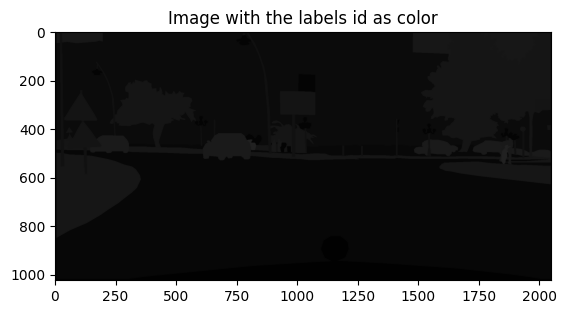

Different values with the categories id : [0 1 2 3 4 5 6 7]


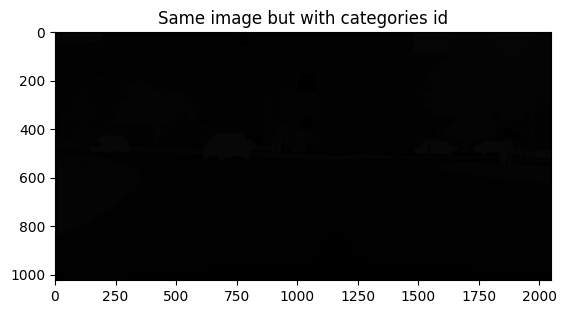

In [7]:
image = cv2.imread(r"C:\Users\barau\Documents\FormationOpenClassrooms\Projet8\data-segmentation\dataset\gtFine\train\aachen\aachen_000000_000019_gtFine_labelIds.png", cv2.IMREAD_COLOR)
print(f"Different values with the labels id : {np.unique(image)}")
plt.imshow(image)
plt.title("Image with the labels id as color")
plt.show()


image = matrixId2categoryId(image)

print(f"Different values with the categories id : {np.unique(image)}")
image = image.astype(np.uint8)
plt.imshow(image)
plt.title("Same image but with categories id")
plt.show()

## Data augmentation

Because we have a lot of data but very similar data (frames differ lightly from each other), we will use data augmentation to increase divergence over the data.
From [this article](https://nbviewer.org/github/aleju/imgaug-doc/blob/master/notebooks/C03%20-%20Stochastic%20and%20Deterministic%20Augmentation.ipynb), we can see that we can just feed the image and the labels in the same function to apply the same transformation.

> Note: While it is possible to augment multi-input data (e.g. images + bounding boxes) by switching manually to deterministic mode, as described in this notebook, the recommended way is to feed all inputs at the same time into the augmentation call. E.g. one could use augmenter(images=images, bounding_boxes=bbs) to augment both images and bounding boxes on them in the same way. Aside from images and bounding_boxes, the method also accepts heatmaps, segmentation_maps, keypoints, line_strings and polygons as parameters.

Doc [here](https://imgaug.readthedocs.io/en/latest/source/examples_segmentation_maps.html) and notebook on segmentation map augmentation [here](https://nbviewer.org/github/aleju/imgaug-doc/blob/master/notebooks/B05%20-%20Augment%20Segmentation%20Maps.ipynb)

In [1]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapOnImage
import random
from tqdm import tqdm

seq = iaa.Sequential([
    iaa.Crop(px=(0, 50)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)), # blur images with a sigma of 0 to 3.0
    iaa.Affine(rotate=(-45, 45)), # Add rotation
])

def augment_seg( img , seg  ):
	# Make the sequence of transformation deterministic, meaning that the parameters aren't randomized at every call
    # Useful for dual image transformation like our image/label pair
	aug_det = seq.to_deterministic() 

    # Augment the image or the batch
	image_aug = aug_det.augment_image( img )

    # Create a segmentation map (what we call labels)
	segmap = SegmentationMapOnImage( seg , shape=img.shape , nb_classes=8)
    # Get only the augmentation that will be applied to the segmentation labels (etc : flip : yes, crop : yes, blur : no)
	segmap_aug = aug_det.augment_segmentation_maps( segmap )

	return image_aug , segmap_aug

def augment_images(folder_images, folder_label, augment_percentage):
    print(f"Augmenting images in {folder_images} ...")
    images_list_in_folder = os.listdir(folder_images)
    base_url = os.path.dirname(folder_images)
    nb_images = int(len(images_list_in_folder) * augment_percentage)
    print(f"{nb_images} images will be augmented")

    choosen_images = random.choices(images_list_in_folder, k=nb_images)

    for image in tqdm(choosen_images):
        image_path = os.path.join(folder_images, image)
        print(f"Augmenting : {image_path}")
        label_path = os.path.join(folder_label, image)
        print(f"Label path : {label_path}")


        img = cv2.imread(image_path)
        seg = cv2.imread(label_path)[:,:,:1]
        image_aug , segmap_aug = augment_seg(img, seg)
        
        augment_image_url = os.path.join(folder_images, f"augmented_{image}")
        print(f"Augmented image url : {augment_image_url}")
        cv2.imwrite(augment_image_url, image_aug)

        augment_label_url = os.path.join(folder_label, f"augmented_{image}")
        print(f"Augmented label url : {augment_label_url}")
        cv2.imwrite(augment_label_url, segmap_aug.get_arr_int())
    

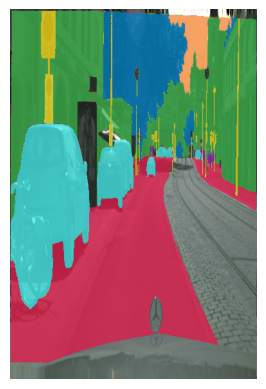

In [12]:
# useful just to export frames with the segmentation

import cv2
import matplotlib.pyplot as plt
import random
from imgaug.augmentables.segmaps import SegmentationMapOnImage

#list every image in the folder
images = os.listdir("processed_data\\training_data\\")
random_images = random.choices(images, k=10)

for image in random_images:
    # read the image
    img = cv2.imread(f"processed_data\\training_data\\{image}")
    # read the label
    label = cv2.imread(f"processed_data\\training_labels\\{image}")[:,:,:1]
    
    segmap = SegmentationMapOnImage( label , shape=img.shape , nb_classes=8)
    plt.imshow(segmap.draw_on_image(img))
    plt.axis('off')
    plt.savefig(f'{image}.png', bbox_inches='tight', pad_inches=0)

In [42]:
image = cv2.imread(r"processed_data\training_data\aachen_000005_000019.png", cv2.IMREAD_COLOR)
image_segmentation = cv2.imread(r"processed_data\training_labels\aachen_000005_000019.png", cv2.IMREAD_COLOR)[:,:,:1]

image_aug, segmap_aug = augment_seg(image, image_segmentation)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
axes[0,0].imshow(image)
axes[0,0].set_title("Original image")
axes[0,1].imshow(segmap.draw_on_image(image))
axes[0,1].set_title("Original image with segmentation map")

axes[1,0].imshow(image_aug)
axes[1,0].set_title("Original image with augmentation")
axes[1,1].imshow(segmap_aug.draw_on_image(image_aug))
axes[1,1].set_title("Original image with augmentation and segmentation map")

plt.show()

Converting labels in processed_data\training_labels\ ...


  3%|▎         | 22/842 [00:13<08:19,  1.64it/s]


KeyboardInterrupt: 

# Getting familiar with the keras_segmentation library

## Testing a model with a pre-trained model

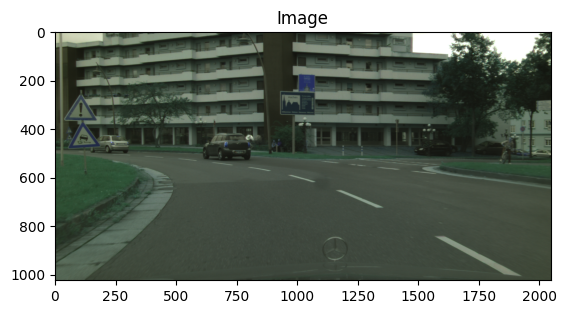

1/1 [==============================] - 2s 2s/step


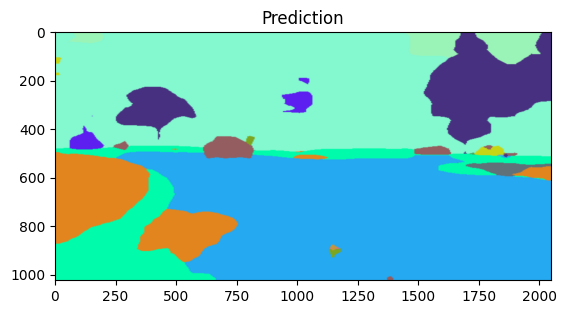

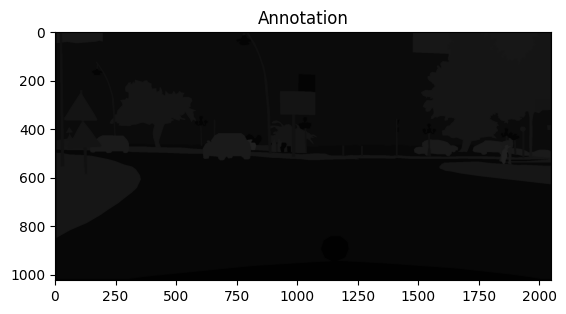

In [10]:
# Test of the module with pre-trained model
from keras_segmentation.pretrained import pspnet_50_ADE_20K


model = pspnet_50_ADE_20K()

test_image = r"C:\Users\barau\Documents\FormationOpenClassrooms\Projet8\data-segmentation\dataset\leftImg8bit\train\aachen\aachen_000000_000019_leftImg8bit.png"

test_image_label = r"C:\Users\barau\Documents\FormationOpenClassrooms\Projet8\data-segmentation\dataset\gtFine\train\aachen\aachen_000000_000019_gtFine_labelIds.png"

base_image = cv2.imread(test_image, cv2.IMREAD_COLOR)
plt.imshow(base_image)
plt.title("Image")
plt.show()

model.predict_segmentation(
    inp=test_image,
    out_fname="out.png"
)

img = cv2.imread("out.png")
plt.title("Prediction")
plt.imshow(img)
plt.show()

img_annotation = cv2.imread(test_image_label)
plt.title("Annotation")
plt.imshow(img_annotation)
plt.show()


In [73]:
import random
import imgaug
import keras

# It is not possible to evaluate this model because it was trained on other classes/labels than the ones we want to predict
# But for future models :

def show_metrics(evaluation):
    print(f"Mean IU : {round(evaluation['mean_IU'],3)}")
    categories_set = {label.categoryId : label.name for label in labels}
    for i, cat in enumerate(categories_set):
        print(f"-- {categories_set[cat]} : {round(evaluation['class_wise_IU'][i],3)} IU")

def keras_evaluate(model, validation_data_folder, validation_labels_folder):
    # Via keras segmentation. We'll prefer doing our own calculations
    evaluation = model.evaluate_segmentation(inp_images_dir=validation_data_folder  , annotations_dir=validation_labels_folder)
    show_metrics(evaluation)

def make_predictions(model, validation_data_folder, validation_labels_folder, validation_labels_pred_folder):
    # Predict every images in the validation folder
    for i, image in enumerate(os.listdir(validation_data_folder)):
        # Getting path of image, label and label_pred
        image_path = os.path.join(validation_data_folder, image)
        label_pred_path = os.path.join(validation_labels_pred_folder, image)

        # prediction
        out = model.predict_segmentation(inp=image_path, out_fname=label_pred_path)
        # creating the prediction file
        cv2.imwrite(label_pred_path, out)

    return validation_labels_pred_folder

def display_one_prediction(validation_data_folder, validation_labels_folder, validation_labels_pred_folder):

    # pick one image
    image_name = random.choice(os.listdir(validation_data_folder))
    # read image
    image = cv2.imread(os.path.join(validation_data_folder, image_name))

    # read label and prediction
    label_path = os.path.join(validation_labels_folder, image_name)
    label = cv2.imread(label_path)[:, :, :1]

    label_pred_path = os.path.join(validation_labels_pred_folder, image_name)
    label_pred = cv2.imread(label_pred_path)[:, :, :1]

    # display
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
    axes[0].imshow(image)
    axes[0].set_title("Image")

    seg_label_map = imgaug.augmentables.segmaps.SegmentationMapOnImage(
        label, shape=image.shape, nb_classes=8
    )
    segmentation_image = seg_label_map.draw_on_image(image)
    axes[1].imshow(segmentation_image)
    axes[1].set_title("Annotation")

    seg_label_pred_map = imgaug.augmentables.segmaps.SegmentationMapOnImage(
        label_pred, shape=image.shape, nb_classes=8
    )
    segmentation_pred_image = seg_label_pred_map.draw_on_image(image)
    axes[2].imshow(segmentation_pred_image)
    axes[2].set_title("Prediction")

    plt.show()


def calculate_metrics(validation_labels_folder, validation_labels_pred_folder):
    # List of every images predicted, with list_metrics[i][0] = mean IoU and list_metrics[i][1:8] = IoU for each of the eight classes
    list_metrics = []


    for i, labels in enumerate(os.listdir(validation_labels_folder)):
        metric = keras.metrics.MeanIoU(num_classes=8)
        metric.reset_states()
        
        list_metric = []
        
        # Open labels
        label = cv2.imread(os.path.join(validation_labels_folder, labels), cv2.IMREAD_COLOR)[:,:,:1]
        label_pred = cv2.imread(os.path.join(validation_labels_pred_folder, labels), cv2.IMREAD_COLOR)[:, :, :1]

        # make sure they are the same size
        label = cv2.resize(label, (label_pred.shape[1], label_pred.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        metric.update_state(label, label_pred)
        list_metric.append(metric.result().numpy())
        for i in range(8):
            metric = keras.metrics.IoU(num_classes=8, target_class_ids=[i])
            metric.reset_states()
            metric.update_state(label, label_pred)
            list_metric.append(metric.result().numpy())

        list_metrics.append(list_metric)

    # Make the mean of all the metrics
    mean_metrics = np.mean(list_metrics, axis=0)
    print("Mean IoU :", mean_metrics[0])
    print("IoU for each class :")
    for i in range(1, 8):
        print(f"Class {i} : {mean_metrics[i]}")

    return mean_metrics




def evaluate_seg_model(model, validation_data_folder, validation_labels_folder, validation_labels_pred_folder, prediction = True, display = True):
    if prediction:
        make_predictions(model, validation_data_folder, validation_labels_folder, validation_labels_pred_folder)

    if display:
        display_one_prediction(validation_data_folder, validation_labels_folder, validation_labels_pred_folder)
    
    # Calculating metrics
    metrics = calculate_metrics(validation_labels_folder, validation_labels_pred_folder)

    return metrics

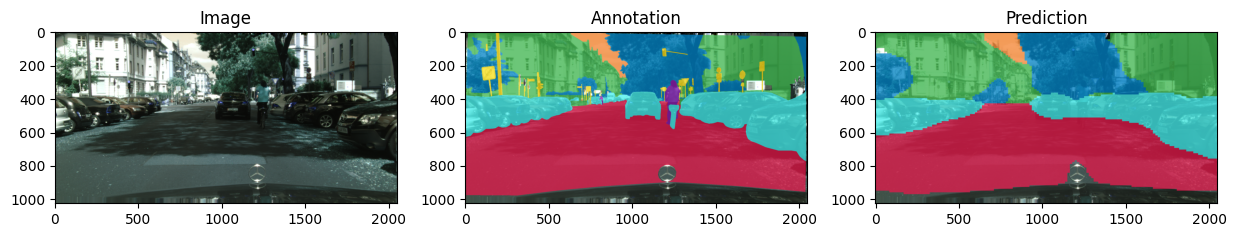

Mean IoU : 0.5290051
IoU for each class :
Class 1 : 0.5151456594467163
Class 2 : 0.9214332699775696
Class 3 : 0.7132500410079956
Class 4 : 0.02616487443447113
Class 5 : 0.702521800994873
Class 6 : 0.48381519317626953
Class 7 : 0.12536022067070007


In [71]:
from keras_segmentation.models.pspnet import vgg_pspnet
model = vgg_pspnet(n_classes=8,input_height=384, input_width=576)
model.load_weights(r'C:\Users\barau\Documents\FormationOpenClassrooms\Projet8\data-segmentation\tmp\vgg_pspnet\2022-09-09_09-28-20\vgg_pspnet_13.h5')


validation_labels_pred_folder = validation_labels_folder.replace("validation_labels", "validation_labels_pred")
mean_metrics = evaluate_seg_model(model, validation_data_folder, validation_labels_folder, validation_labels_pred_folder, prediction = False)

In [74]:
keras_evaluate(model, validation_data_folder, validation_labels_folder)

0it [00:00, ?it/s]

1/1 [==============================] - 1s 532ms/step


1it [00:00,  1.51it/s]

1/1 [==============================] - 0s 404ms/step


2it [00:01,  1.72it/s]

1/1 [==============================] - 0s 398ms/step


3it [00:01,  1.81it/s]

1/1 [==============================] - 0s 425ms/step


4it [00:02,  1.83it/s]

1/1 [==============================] - 0s 436ms/step


5it [00:02,  1.82it/s]

1/1 [==============================] - 0s 426ms/step


6it [00:03,  1.82it/s]

1/1 [==============================] - 0s 429ms/step


7it [00:03,  1.83it/s]

1/1 [==============================] - 0s 422ms/step


8it [00:04,  1.85it/s]

1/1 [==============================] - 0s 389ms/step


9it [00:04,  1.89it/s]

1/1 [==============================] - 0s 397ms/step


10it [00:05,  1.84it/s]

Mean IU : 0.593
-- ground : 0.53 IU
-- rail track : 0.923 IU
-- tunnel : 0.727 IU
-- traffic sign : 0.029 IU
-- terrain : 0.727 IU
-- sky : 0.641 IU
-- rider : 0.408 IU
-- license plate : 0.758 IU


# Training model from scratch

A segmentation model is composed by an encoder and a decoder.

The model we will use here is called fcn_32 (`fcn` because of its architecture, FullyConvolutionnalNetwork) and 32 because the result has been upsampled 32 times. It is a lot compared to fcn_8 so it will have worse results but it will be faster to train.

From [this article](https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1).

![upsamplingExplainingFCNDifference](https://miro.medium.com/max/875/1*lUnNaKAjL-Mq10v3tIBtJg.png)

After selecting our architecture, we'll have to choose our decoder. Here we chose "vanilla_encoder" from [here](https://github.com/divamgupta/image-segmentation-keras/blob/master/keras_segmentation/models/basic_models.py). This encoder isn't already trained on ImageNet (unlike Unet, MobileNet or ResNet) so the reasults will be poor. But I think it is a good start.

In [5]:
# First, we need to convert labels to categorical

convert_labels(training_labels_folder)
convert_labels(validation_labels_folder)

Converting labels in processed_data\training_labels ...


100%|██████████| 848/848 [08:37<00:00,  1.64it/s]


Done
Converting labels in processed_data\validation_labels ...


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]

Done


In [8]:
import pickle

from keras_segmentation.models.fcn import fcn_32
from keras.callbacks import ModelCheckpoint
from keras_segmentation.train import train

model = fcn_32(n_classes=8 ,  input_height=416, input_width=608)

# Creating checkpoint folder
checkpoint_folder = f"tmp\{model.model_name}"
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)

# If there is a checkpoint, load it
if os.path.exists(os.path.join(checkpoint_folder, "checkpoint")):
    model.load_weights(os.path.join(checkpoint_folder, "model.h5"))
    print("Model loaded.")


model_checkpoint = ModelCheckpoint(
    os.path.join(checkpoint_folder, model.model_name + "_{epoch:02d}.h5"),
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=False,)

train(
    model,
    train_images =  training_data_folder,
    train_annotations = training_labels_folder,
    checkpoints_path = checkpoint_folder + f"\{model.model_name}.ckpt",
    epochs=10,
    verify_dataset = False,
    callbacks=[model_checkpoint]
    )

model.save(os.path.join(checkpoint_folder, "model.h5"))

c:\Users\barau\Documents\FormationOpenClassrooms\Projet8\data-segmentation\env\lib\site-packages\keras_segmentation\train.py:171: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, steps_per_epoch,


Epoch 1/10
512/512 [==============================] - ETA: 0s - loss: 2.0794 - accuracy: 0.1273
Epoch 1: saving model to tmp\fcn_32\fcn_32_01.h5
512/512 [==============================] - 1732s 3s/step - loss: 2.0794 - accuracy: 0.1273
Epoch 2/10
512/512 [==============================] - ETA: 0s - loss: 2.0792 - accuracy: 0.1301
Epoch 2: saving model to tmp\fcn_32\fcn_32_02.h5
512/512 [==============================] - 1746s 3s/step - loss: 2.0792 - accuracy: 0.1301
Epoch 3/10
512/512 [==============================] - ETA: 0s - loss: 2.0790 - accuracy: 0.1334
Epoch 3: saving model to tmp\fcn_32\fcn_32_03.h5
512/512 [==============================] - 1637s 3s/step - loss: 2.0790 - accuracy: 0.1334
Epoch 4/10
512/512 [==============================] - ETA: 0s - loss: 2.0786 - accuracy: 0.1378
Epoch 4: saving model to tmp\fcn_32\fcn_32_04.h5
512/512 [==============================] - 1630s 3s/step - loss: 2.0786 - accuracy: 0.1378
Epoch 5/10
512/512 [==============================] - ET

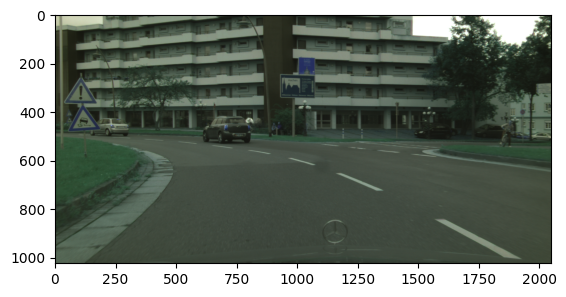

1/1 [==============================] - 1s 865ms/step


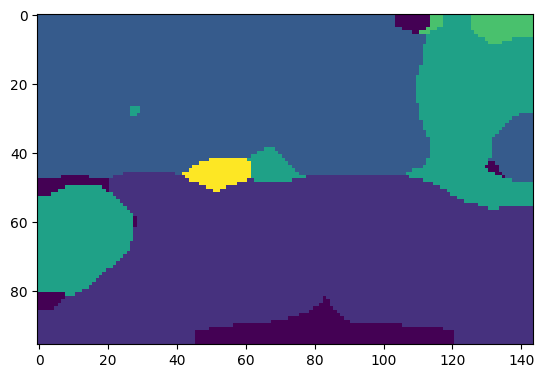

In [16]:
test_image = r"C:\Users\barau\Documents\FormationOpenClassrooms\Projet8\data-segmentation\dataset\leftImg8bit\train\aachen\aachen_000000_000019_leftImg8bit.png"

test_image_label = r"C:\Users\barau\Documents\FormationOpenClassrooms\Projet8\data-segmentation\dataset\gtFine\train\aachen\aachen_000000_000019_gtFine_labelIds.png"

plt.imshow(cv2.imread(test_image, cv2.IMREAD_COLOR))
plt.show()

out = model.predict_segmentation(
    inp=test_image,
    out_fname="out.png"
)

plt.imshow(out)
plt.show()

In [17]:
evaluate_seg_model(model, validation_data_folder, validation_labels_folder)

0it [00:00, ?it/s]

1/1 [==============================] - 0s 479ms/step


1it [00:00,  1.89it/s]

1/1 [==============================] - 0s 458ms/step


2it [00:01,  1.93it/s]

1/1 [==============================] - 0s 405ms/step


3it [00:01,  2.04it/s]

1/1 [==============================] - 0s 428ms/step


4it [00:01,  2.05it/s]

1/1 [==============================] - 0s 404ms/step


5it [00:02,  2.10it/s]

1/1 [==============================] - 0s 413ms/step


6it [00:02,  2.12it/s]

1/1 [==============================] - 0s 417ms/step


7it [00:03,  2.11it/s]

1/1 [==============================] - 0s 397ms/step


8it [00:03,  2.15it/s]

1/1 [==============================] - 0s 398ms/step


9it [00:04,  2.18it/s]

1/1 [==============================] - 0s 393ms/step


10it [00:04,  2.19it/s]

1/1 [==============================] - 0s 410ms/step


11it [00:05,  2.19it/s]

1/1 [==============================] - 0s 449ms/step


12it [00:05,  2.13it/s]

1/1 [==============================] - 0s 450ms/step


13it [00:06,  2.07it/s]

1/1 [==============================] - 0s 446ms/step


14it [00:06,  2.04it/s]

1/1 [==============================] - 0s 450ms/step


15it [00:07,  2.01it/s]

1/1 [==============================] - 0s 450ms/step


16it [00:07,  2.00it/s]

1/1 [==============================] - 0s 442ms/step


17it [00:08,  2.02it/s]

1/1 [==============================] - 0s 451ms/step


18it [00:08,  2.01it/s]

1/1 [==============================] - 0s 435ms/step


19it [00:09,  2.01it/s]

1/1 [==============================] - 0s 402ms/step


20it [00:09,  2.05it/s]

1/1 [==============================] - 0s 398ms/step


21it [00:10,  2.10it/s]

1/1 [==============================] - 0s 397ms/step


22it [00:10,  2.14it/s]

1/1 [==============================] - 0s 415ms/step


23it [00:11,  2.14it/s]

1/1 [==============================] - 0s 411ms/step


24it [00:11,  2.15it/s]

1/1 [==============================] - 0s 416ms/step


25it [00:11,  2.15it/s]

1/1 [==============================] - 0s 400ms/step


26it [00:12,  2.18it/s]

1/1 [==============================] - 0s 395ms/step


27it [00:12,  2.20it/s]

1/1 [==============================] - 0s 394ms/step


28it [00:13,  2.22it/s]

1/1 [==============================] - 0s 397ms/step


29it [00:13,  2.22it/s]

1/1 [==============================] - 0s 397ms/step


30it [00:14,  2.23it/s]

1/1 [==============================] - 0s 393ms/step


31it [00:14,  2.24it/s]

1/1 [==============================] - 0s 401ms/step


32it [00:15,  2.24it/s]

1/1 [==============================] - 0s 397ms/step


33it [00:15,  2.25it/s]

1/1 [==============================] - 0s 398ms/step


34it [00:15,  2.25it/s]

1/1 [==============================] - 0s 406ms/step


35it [00:16,  2.24it/s]

1/1 [==============================] - 0s 458ms/step


36it [00:16,  2.13it/s]

1/1 [==============================] - 0s 414ms/step


37it [00:17,  2.13it/s]

1/1 [==============================] - 0s 401ms/step


38it [00:17,  2.13it/s]

Mean IU : 0.065
-- ground : 0.094 IU
-- rail track : 0.201 IU
-- tunnel : 0.117 IU
-- traffic sign : 0.0 IU
-- terrain : 0.061 IU
-- sky : 0.0 IU
-- rider : 0.0 IU
-- license plate : 0.051 IU


## Training model from a trained encoder (mobileNet)

Now that we found that our previous results weren't very good, we'll try another approach with a different architecture and a different encoder.

The encoder used will be VGG16 with a PSPNet architecture (from [here](https://github.com/divamgupta/image-segmentation-keras/blob/b9171a326502587fdd089754234967416631f482/keras_segmentation/models/pspnet.py#L85)).

In [66]:
# Resizing images
resize_images(training_data_folder, (384, 576))
resize_images(training_labels_folder, (384, 576))
resize_images(validation_data_folder, (384, 576))
resize_images(validation_labels_folder, (384, 576))

# Converting labels to categorical
convert_labels(training_labels_folder)
convert_labels(validation_labels_folder)

# Data augmentation
augment_images(r"processed_data\training_data", r"processed_data\training_labels", 10)

Resizing training images in processed_data\training_data to (384, 576) ...


100%|██████████| 834/834 [00:39<00:00, 21.11it/s]


Done
Resizing training images in processed_data\training_labels to (384, 576) ...


100%|██████████| 834/834 [00:21<00:00, 39.17it/s]


Done
Resizing training images in processed_data\validation_data to (384, 576) ...


100%|██████████| 47/47 [00:00<00:00, 51.29it/s]


Done
Resizing training images in processed_data\validation_labels to (384, 576) ...


100%|██████████| 47/47 [00:00<00:00, 112.15it/s]


Done
Converting labels in processed_data\training_labels ...


100%|██████████| 834/834 [00:53<00:00, 15.64it/s]


Done
Converting labels in processed_data\validation_labels ...


100%|██████████| 47/47 [00:02<00:00, 16.39it/s]

Done


NameError: name 'augment_images' is not defined

In [20]:
import pickle

from keras_segmentation.models.pspnet import vgg_pspnet
from keras.callbacks import ModelCheckpoint
from keras_segmentation.train import train
from datetime import datetime

model = vgg_pspnet(n_classes=8,input_height=384, input_width=576)

weights_path = r"tmp\vgg_pspnet\2022-09-08_19-35-00\vgg_pspnet_20.h5"

# Creating checkpoint folder
checkpoint_folder = f"tmp\{model.model_name}\{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
print(f"checkpoint_folder : {checkpoint_folder}")
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)

# If there is a checkpoint, load it
if weights_path != None:
    model.load_weights(weights_path)
    print("Model loaded.")


model_checkpoint = ModelCheckpoint(
    os.path.join(checkpoint_folder, model.model_name + "_{epoch:02d}.h5"),
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=False,)

train(
    model,
    train_images =  training_data_folder,
    train_annotations = training_labels_folder,
    checkpoints_path = checkpoint_folder + f"\{model.model_name}.ckpt",
    epochs=30,
    verify_dataset = False,
    callbacks=[model_checkpoint]
    )

checkpoint_folder : tmp\vgg_pspnet\2022-09-09_09-28-20
Model loaded.
Epoch 1/30
512/512 [==============================] - ETA: 0s - loss: 0.4168 - accuracy: 0.8588
Epoch 1: saving model to tmp\vgg_pspnet\2022-09-09_09-28-20\vgg_pspnet_01.h5
512/512 [==============================] - 2312s 5s/step - loss: 0.4168 - accuracy: 0.8588
Epoch 2/30
512/512 [==============================] - ETA: 0s - loss: 0.4183 - accuracy: 0.8576
Epoch 2: saving model to tmp\vgg_pspnet\2022-09-09_09-28-20\vgg_pspnet_02.h5
512/512 [==============================] - 2123s 4s/step - loss: 0.4183 - accuracy: 0.8576
Epoch 3/30
512/512 [==============================] - ETA: 0s - loss: 0.4146 - accuracy: 0.8589
Epoch 3: saving model to tmp\vgg_pspnet\2022-09-09_09-28-20\vgg_pspnet_03.h5
512/512 [==============================] - 2129s 4s/step - loss: 0.4146 - accuracy: 0.8589
Epoch 4/30
512/512 [==============================] - ETA: 0s - loss: 0.4119 - accuracy: 0.8601
Epoch 4: saving model to tmp\vgg_pspnet\202

KeyboardInterrupt: 

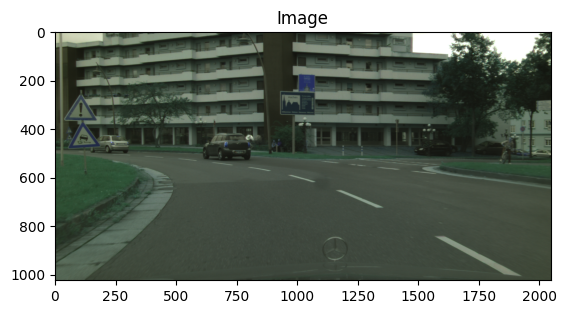

1/1 [==============================] - 1s 537ms/step


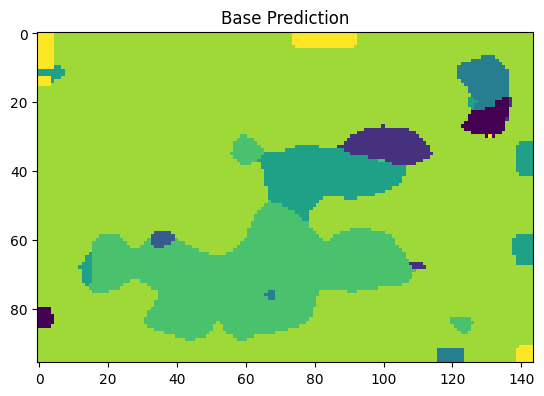

1/1 [==============================] - 0s 414ms/step


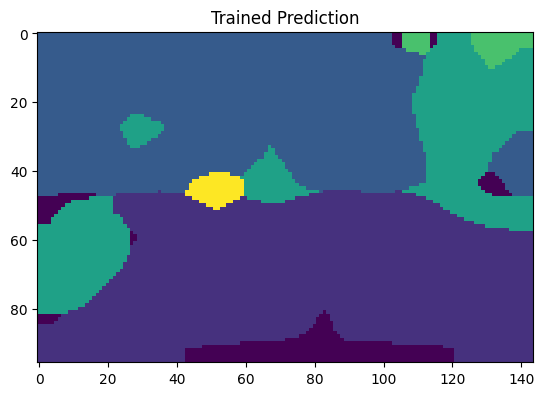

In [23]:

plt.imshow(cv2.imread(test_image, cv2.IMREAD_COLOR))
plt.title("Image")
plt.show()


base_model = vgg_pspnet(n_classes=8,input_height=384, input_width=576)

out_base = base_model.predict_segmentation(
    inp=test_image,
    out_fname="out_base.png"
)

plt.imshow(out_base)
plt.title("Base Prediction")
plt.show()

out = model.predict_segmentation(
    inp=test_image,
    out_fname="out.png"
)

plt.imshow(out)
plt.title("Trained Prediction")
plt.show()

In [25]:
evaluate_seg_model(base_model, validation_data_folder, validation_labels_folder)

evaluate_seg_model(model, validation_data_folder, validation_labels_folder)

0it [00:00, ?it/s]

1/1 [==============================] - 0s 421ms/step


1it [00:00,  2.19it/s]

1/1 [==============================] - 0s 408ms/step


2it [00:00,  2.22it/s]

1/1 [==============================] - 0s 402ms/step


3it [00:01,  2.24it/s]

1/1 [==============================] - 0s 372ms/step


4it [00:01,  2.31it/s]

1/1 [==============================] - 0s 374ms/step


5it [00:02,  2.35it/s]

1/1 [==============================] - 0s 380ms/step


6it [00:02,  2.37it/s]

1/1 [==============================] - 0s 374ms/step


7it [00:02,  2.38it/s]

1/1 [==============================] - 0s 364ms/step


8it [00:03,  2.41it/s]

1/1 [==============================] - 0s 367ms/step


9it [00:03,  2.43it/s]

1/1 [==============================] - 0s 368ms/step


10it [00:04,  2.42it/s]

1/1 [==============================] - 0s 411ms/step


11it [00:04,  2.36it/s]

1/1 [==============================] - 0s 375ms/step


12it [00:05,  2.38it/s]

1/1 [==============================] - 0s 371ms/step


13it [00:05,  2.40it/s]

1/1 [==============================] - 0s 364ms/step


14it [00:05,  2.43it/s]

1/1 [==============================] - 0s 370ms/step


15it [00:06,  2.43it/s]

1/1 [==============================] - 0s 361ms/step


16it [00:06,  2.45it/s]

1/1 [==============================] - 0s 395ms/step


17it [00:07,  2.41it/s]

1/1 [==============================] - 0s 385ms/step


18it [00:07,  2.39it/s]

1/1 [==============================] - 0s 405ms/step


19it [00:08,  2.34it/s]

1/1 [==============================] - 0s 402ms/step


20it [00:08,  2.32it/s]

1/1 [==============================] - 0s 452ms/step


21it [00:08,  2.21it/s]

1/1 [==============================] - 0s 398ms/step


22it [00:09,  2.23it/s]

1/1 [==============================] - 0s 403ms/step


23it [00:09,  2.24it/s]

1/1 [==============================] - 0s 397ms/step


24it [00:10,  2.26it/s]

1/1 [==============================] - 0s 390ms/step


25it [00:10,  2.28it/s]

1/1 [==============================] - 0s 394ms/step


26it [00:11,  2.28it/s]

1/1 [==============================] - 0s 394ms/step


27it [00:11,  2.29it/s]

1/1 [==============================] - 0s 411ms/step


28it [00:12,  2.27it/s]

1/1 [==============================] - 0s 393ms/step


29it [00:12,  2.27it/s]

1/1 [==============================] - 0s 402ms/step


30it [00:12,  2.27it/s]

1/1 [==============================] - 0s 403ms/step


31it [00:13,  2.27it/s]

1/1 [==============================] - 0s 393ms/step


32it [00:13,  2.28it/s]

1/1 [==============================] - 0s 394ms/step


33it [00:14,  2.29it/s]

1/1 [==============================] - 0s 399ms/step


34it [00:14,  2.29it/s]

1/1 [==============================] - 0s 393ms/step


35it [00:15,  2.30it/s]

1/1 [==============================] - 0s 389ms/step


36it [00:15,  2.31it/s]

1/1 [==============================] - 0s 391ms/step


37it [00:15,  2.32it/s]

1/1 [==============================] - 0s 394ms/step


38it [00:16,  2.32it/s]


Mean IU : 0.018
-- ground : 0.014 IU
-- rail track : 0.005 IU
-- tunnel : 0.058 IU
-- traffic sign : 0.003 IU
-- terrain : 0.048 IU
-- sky : 0.003 IU
-- rider : 0.002 IU
-- license plate : 0.009 IU


0it [00:00, ?it/s]

1/1 [==============================] - 0s 446ms/step


1it [00:00,  2.03it/s]

1/1 [==============================] - 0s 434ms/step


2it [00:00,  2.08it/s]

1/1 [==============================] - 0s 421ms/step


3it [00:01,  2.12it/s]

1/1 [==============================] - 0s 410ms/step


4it [00:01,  2.16it/s]

1/1 [==============================] - 0s 455ms/step


5it [00:02,  2.11it/s]

1/1 [==============================] - 0s 431ms/step


6it [00:02,  2.11it/s]

1/1 [==============================] - 1s 522ms/step


7it [00:03,  1.98it/s]

1/1 [==============================] - 0s 424ms/step


8it [00:03,  2.03it/s]

1/1 [==============================] - 0s 397ms/step


9it [00:04,  2.11it/s]

1/1 [==============================] - 0s 442ms/step


10it [00:04,  2.09it/s]

1/1 [==============================] - 0s 434ms/step


11it [00:05,  2.10it/s]

1/1 [==============================] - 0s 458ms/step


12it [00:05,  2.07it/s]

1/1 [==============================] - 0s 441ms/step


13it [00:06,  2.06it/s]

1/1 [==============================] - 0s 405ms/step


14it [00:06,  2.11it/s]

1/1 [==============================] - 0s 412ms/step


15it [00:07,  2.14it/s]

1/1 [==============================] - 0s 412ms/step


16it [00:07,  2.16it/s]

1/1 [==============================] - 0s 453ms/step


17it [00:08,  2.12it/s]

1/1 [==============================] - 0s 421ms/step


18it [00:08,  2.13it/s]

1/1 [==============================] - 0s 449ms/step


19it [00:09,  2.10it/s]

1/1 [==============================] - 0s 423ms/step


20it [00:09,  2.11it/s]

1/1 [==============================] - 0s 409ms/step


21it [00:09,  2.15it/s]

1/1 [==============================] - 0s 411ms/step


22it [00:10,  2.17it/s]

1/1 [==============================] - 0s 431ms/step


23it [00:10,  2.15it/s]

1/1 [==============================] - 0s 410ms/step


24it [00:11,  2.17it/s]

1/1 [==============================] - 0s 432ms/step


25it [00:11,  2.16it/s]

1/1 [==============================] - 0s 425ms/step


26it [00:12,  2.15it/s]

1/1 [==============================] - 0s 426ms/step


27it [00:12,  2.15it/s]

1/1 [==============================] - 0s 411ms/step


28it [00:13,  2.17it/s]

1/1 [==============================] - 0s 409ms/step


29it [00:13,  2.19it/s]

1/1 [==============================] - 0s 393ms/step


30it [00:14,  2.21it/s]

1/1 [==============================] - 0s 394ms/step


31it [00:14,  2.24it/s]

1/1 [==============================] - 0s 436ms/step


32it [00:15,  2.20it/s]

1/1 [==============================] - 0s 414ms/step


33it [00:15,  2.20it/s]

1/1 [==============================] - 0s 431ms/step


34it [00:15,  2.17it/s]

1/1 [==============================] - 0s 419ms/step


35it [00:16,  2.17it/s]

1/1 [==============================] - 0s 431ms/step


36it [00:16,  2.16it/s]

1/1 [==============================] - 0s 420ms/step


37it [00:17,  2.17it/s]

1/1 [==============================] - 0s 412ms/step


38it [00:17,  2.14it/s]

Mean IU : 0.066
-- ground : 0.098 IU
-- rail track : 0.2 IU
-- tunnel : 0.115 IU
-- traffic sign : 0.001 IU
-- terrain : 0.063 IU
-- sky : 0.001 IU
-- rider : 0.0 IU
-- license plate : 0.05 IU
